# **Data Loading and Extraction**

**Background**

The section below extracts the 3 files from the CISI data collection:
- CISI.ALL: containing information about the documents.
- CISI.QRY: containing a list of queries to be executed against our retrieval system.
- CISI.REL: contains appropriate relevance assessments to be used in the evaluation of our models.


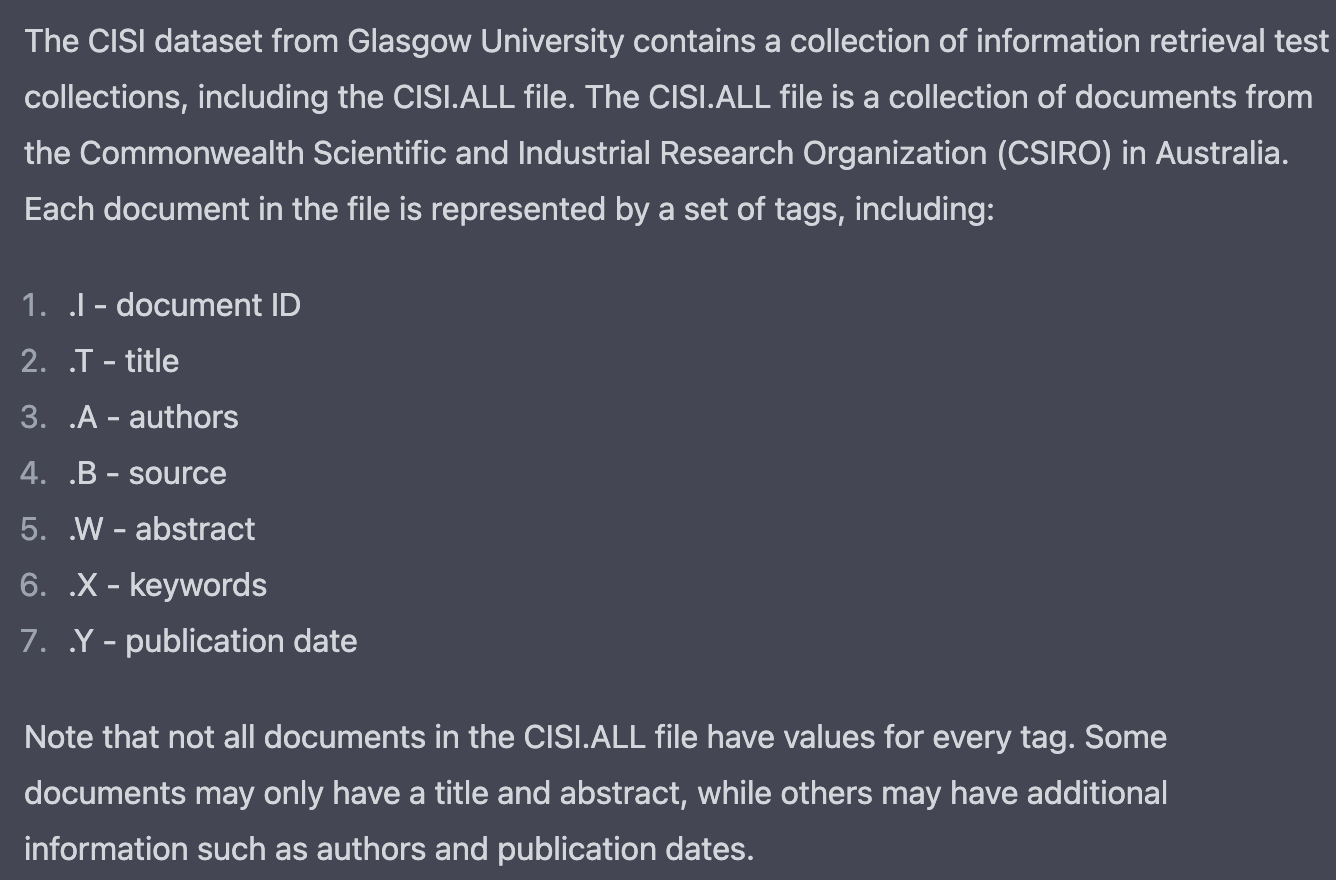

##### **Loading the files**

In [1]:
import os as os
import re

# obtains the current working directory of the notebook
directory = os.getcwd()

# defines paths to CISI dataset files
cisi_all_path = os.path.join(directory, 'CISI.ALL')
cisi_qry_path = os.path.join(directory, 'CISI.QRY')
cisi_rel_path = os.path.join(directory, 'CISI.REL')

##### **CISI.ALL Extraction**

In [2]:
# function extracting text in the CISI.ALL file line by line and populating id, title, author, abstract and publication information fields
def all_extraction(file_name_path):
    with open(file_name_path) as f:
        file_lines = f.readlines()

    doc_ids = []
    documents = []
    i = 0
    while i < len(file_lines):
        if file_lines[i].startswith(".I"): # if a line starts with '.I', the following line will be the document ID
            doc_id = file_lines[i].split()[1]
            doc_ids.append(doc_id)
            if file_lines[i+1].startswith(".T") and file_lines[i+3].startswith(".A"): # selecting text between the .T and .A tags
                title = file_lines[i+2][:].strip() # saved into the title tag
            else:
                title = file_lines[i+2].strip() + " " + file_lines[i+3].strip()
            authors = ""
            if any([line.startswith(".A") for line in file_lines[i+1:]]): # selecting text after the .A tag
                author_start = i+4 # saved as author 
                author_end = author_start
                while author_end < len(file_lines) and not any([file_lines[author_end].startswith(tag) for tag in [".T", ".B", ".W", ".Y"]]):
                    author_end += 1 # checks for documents with multiple authors 
                authors = " ".join([file_lines[j].strip() for j in range(author_start, author_end)]).strip()
                authors = re.sub(r"^\s*\.\s*A\s*", "", authors)
                abstract_start = author_end # selects text after the author lines as the start of the abstract
            else:
                abstract_start = i+4

            for t in range(i+4, len(file_lines)):
                if file_lines[t].startswith(".X"): # abstract text ends before the .X keywords tag
                    abstract_end = t
                    break
            else:
                abstract_end = len(file_lines)
            abstract = " ".join(file_lines[abstract_start:abstract_end]).strip().replace('\n', ' ')
            abstract = re.sub(r"^\s*\.\s*W\s*", "", abstract)
            abstract = " ".join(abstract.split())
            source = re.search(r"\.B\s+(.*)\.W", abstract)
            if source: # saves source information (.B) if present
                source = source.group(1)
                source = re.sub(r"^\s*\.\s*A\s*", "", source)
                source = re.sub(r"^\s*\.\s*B\s*", "", source)
            else:
                source = ""
            abstract = re.sub(r"^\s*\.\s*B\s*(.*)\.W", "", abstract)
            abstract = " ".join(abstract.split())
            year = re.search(r"\.Y\s+(\d{4})", abstract)
            if year: # saves publication date (.Y) if present
                year = int(year.group(1))
            else:
                year = ""
            abstract = re.sub(r"^\s*\.\s*Y\s*\d{4}\s*", "", abstract)
            abstract = " ".join(abstract.split())
            documents.append({"document_id": doc_id, "title": title, "authors": authors, "abstract": abstract, "source": source, "year": year})
            i = abstract_end
        else:
            i += 1

    return documents

In [3]:
documents = all_extraction(cisi_all_path)
#documents

##### **CISI.QRY Extraction**

**sabos query extraction - ran**

In [4]:
# function extracting data from CISI.QRY file line by line
def qry_extraction(filename_path, tag):
    with open (filename_path,'r') as f:
        all_text = f.read().replace('\n'," ")
        file_lines = re.split(tag,all_text)
        file_lines.pop(0)
        return file_lines

In [5]:
# organising text into query id and query text
doc_id_tag = re.compile('\.I.')
cisi_qry = qry_extraction(cisi_qry_path, doc_id_tag) 
queries = []
for i, d in enumerate(cisi_qry):
    query_id, query_text = d.split(' ', 1)
    query_text = query_text.split('.W', 1)[1].strip()
    query_text = re.sub(r'\.B\s.*', '', query_text).strip()
    queries.append({'query_id': int(query_id), 'query_text': query_text})

In [6]:
queries[0]

{'query_id': 1,
 'query_text': 'What problems and concerns are there in making up descriptive titles? What difficulties are involved in automatically retrieving articles from approximate titles? What is the usual relevance of the content of articles to their titles?'}

**sobs query extraction - NOT RAN>>>**

In [10]:
# query extraction from CISI.QRY file (1st 57 queries only)
def extraction_query(file_name_path):
    with open(file_name_path) as f:
        file_lines = f.readlines()

    queries_1 = []
    i = 0
    while i < len(file_lines):
        if file_lines[i].startswith(".I"):
            query_id = int(file_lines[i][3:])
            if query_id > 57:
                break
            if file_lines[i+1].startswith(".W"):
                query_text = file_lines[i+2].strip()
                for t in range(i+3, len(file_lines)):
                    if file_lines[t].startswith(".I"):
                        break
                    query_text += " " + file_lines[t].strip()
            else:
                query_text = ""
            queries_1.append({"query_id": query_id, "query_text": query_text})
        i += 1

    return queries_1
     

In [ ]:
# query extraction from CISI.QRY file (58th query onwards)
def extraction_remaining_queries(file_name_path):
    with open(file_name_path) as f:
        file_lines = f.readlines()

    queries = []
    i = 0
    while i < len(file_lines):
        if file_lines[i].startswith(".I"):
            query_id = int(file_lines[i][3:])
            if query_id > 57:
                query_title = ""
                query_author = ""
                query_text = ""
                query_source = ""
                found_text_field = False
                found_source_field = False
                for t in range(i+1, len(file_lines)):
                    if file_lines[t].startswith(".I"):
                        break
                    elif file_lines[t].startswith(".T"):
                        query_title += file_lines[t][3:].strip()
                        # Check if the next line starts with .A and the line after that starts with .T
                        next_t = t+1
                        if next_t < len(file_lines) and file_lines[next_t].startswith(".A") and (next_t+1) < len(file_lines) and file_lines[next_t+1].startswith(".T"):
                            query_title += " " + file_lines[next_t].strip()
                            next_t += 1
                        # Check if the next line also contains title text
                        while next_t < len(file_lines) and not file_lines[next_t].startswith(".I") and not file_lines[next_t].startswith(".A") and not file_lines[next_t].startswith(".W") and not file_lines[next_t].startswith(".B"):
                            query_title += " " + file_lines[next_t].strip()
                            next_t += 1
                    elif file_lines[t].startswith(".A"):
                        query_author += file_lines[t+1][3:].strip()
                        # Check if the next line also contains author text
                        next_t = t+1
                        while next_t < len(file_lines) and not file_lines[next_t].startswith(".I") and not file_lines[next_t].startswith(".T") and not file_lines[next_t].startswith(".W") and not file_lines[next_t].startswith(".B") and not file_lines[next_t].startswith(".A"):
                            query_author += ", " + file_lines[next_t].strip()
                            next_t += 1
                            query_author += ", " + file_lines[next_t].strip()
                            next_t += 1
                    elif file_lines[t].startswith(".W"):
                        found_text_field = True
                        query_text = re.sub(r'^\.W\s*', '', file_lines[t].strip())  # Use regex to remove ".W" tag from the beginning of the line
                        for u in range(t+2, len(file_lines)):
                            if file_lines[u].startswith(".I") or file_lines[u].startswith(".B"):
                                break
                            query_text += " " + file_lines[u].strip()
                    elif file_lines[t].startswith(".B"):
                        found_source_field = True
                        query_source = file_lines[t][3:].strip()
                        for u in range(t+1, len(file_lines)):
                            if file_lines[u].startswith(".I"):
                                break
                            query_source += " " + file_lines[u].strip()
                    elif not found_text_field and not found_source_field:
                        # Assume any field that appears before the .W and .B field is either the title or author
                        if not query_title:
                            query_title = file_lines[t].strip()
                        elif query_author:
                            query_author = file_lines[t-1].strip()
                            query_author += file_lines[t].strip()
                queries.append({"query_id": query_id, "query_title": query_title, "query_author": query_author, "query_text": query_text, "query_source": query_source})
        i += 1

    return queries

In [ ]:
queries_1 = extraction_query(cisi_qry_path)
queries_2 = extraction_remaining_queries(cisi_qry_path)
queries_all = queries_1 + queries_2

##### **CISI.REL Extraction**

In [7]:
import pandas as pd
rel_df = pd.read_csv('CISI.REL', names=['query_id', 'document_id', 'relevance', 'score'], delimiter='\s+') # reads the file and loads in as a dataframe
rel_df = rel_df.drop(columns=['relevance', 'score']) # drop relevance and score columns because they are 0.
print(rel_df.isnull().values.any()) # checking for any NaN values or errors in the extraction
rel_df.head()

False


,query_id,document_id
0,1,28
1,1,35
2,1,38
3,1,42
4,1,43


In [8]:
# converting dataframe into a dictionary using query id as key and document ids as values
query_ids = rel_df['query_id'].unique()
rel_dict = {}

for query_id in query_ids:
    documents1 = rel_df[rel_df['query_id'] == query_id]['document_id'].tolist()
    rel_dict[query_id] = documents1

# converting our dictionary into a list for easier visualisation
rel_list = [(k, v) for k, v in rel_dict.items()]

In [9]:
# reformatting 'rel_list' for easier visualisation
relevant_documents = [(query_id, document_ids) for query_id, document_ids in rel_list]
relevant_documents = [{'query_id': query_id, 'relevant_document_ids': document_ids} for query_id, document_ids in rel_list]
relevant_documents[2] # print out the first query and its top 10 results just to see the formatting

{'query_id': 3,
 'relevant_document_ids': [60,
  85,
  114,
  123,
  126,
  131,
  133,
  136,
  138,
  140,
  346,
  359,
  363,
  372,
  412,
  445,
  454,
  461,
  463,
  469,
  532,
  537,
  540,
  553,
  554,
  555,
  585,
  590,
  599,
  640,
  660,
  664,
  803,
  901,
  909,
  911,
  1027,
  1053,
  1169,
  1179,
  1181,
  1190,
  1191,
  1326]}

# **Pre-processing the Data**

The following NLP preprocessing steps will be administered to both the document and query data:

1.   Tokenizing
2.   Converting text to lowercase
3.   Removing stopwords
4.   Removing special characters, numbers, and punctuation marks

In [10]:
# importing relevant NLP pre-processing libraries
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

**Pre-processing the document data and generating the corpus**

In [11]:
# defining pre-processing tools
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

corpus = []

for document in documents:
    text = ""
    if "title" in document and document["title"]:
        text += document["title"]
    if "authors" in document and document["authors"]:
        text += " " + document["authors"]
    if "abstract" in document and document["abstract"]:
        text += " " + document["abstract"]
    if text:  # only add non-empty strings to corpus
        # removes special characters, numbers, and punctuation marks
        text = text.translate(str.maketrans('', '', string.punctuation + string.digits))
        # removes quotation marks
        text = text.replace("'", "").replace('"', '')
        # tokenizes and converts to lowercase
        tokens = word_tokenize(text.lower())
        # remove stop words
        filtered_text = [word for word in tokens if word not in stop_words]
        # performs lemmatization
        lemmatized_text = [lemmatizer.lemmatize(word) for word in filtered_text]
        # join tokens back to form a string to generate corpus
        preprocessed_text = ' '.join(lemmatized_text)
        corpus.append(preprocessed_text)

In [12]:
# Printing the 3rd document from corpus to check against CISI.ALL
print(corpus[2])

two kind power essay bibliographic control wilson p relationship organization control writing organization control knowledge information inevitably enter story writing contain along much else great deal mankind stock knowledge information bibliographical control form power knowledge form power familiar slogan claim bibliographical control certain sense power power power obtain knowledge recorded written form writing simply simple way storehouse knowledge satisfactorily discus bibliographical control simply control knowledge information contained writing


**Pre-processing the query terms**

In [13]:
# defining pre-processing tools
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

preprocessed_queries = []

for query in queries:
    query_text = query['query_text']  # extracts query_text from the dictionary
    # tokenizes and converts to lowercase
    tokens = word_tokenize(query_text.lower())
    # removes special characters, numbers, and punctuation marks
    filtered_query = [word for word in tokens if word not in string.punctuation + string.digits]
    # remove quotation marks
    filtered_query = [word.replace("'", "").replace('"', '') for word in filtered_query]
    # remove stop words
    filtered_query = [word for word in filtered_query if word not in stop_words]
    # performs lemmatization
    lemmatized_query = [lemmatizer.lemmatize(word) for word in filtered_query]
    # join tokens back to form a string
    preprocessed_query = ' '.join(lemmatized_query)
    preprocessed_queries.append(preprocessed_query)
    qry_terms_all = preprocessed_queries

In [14]:
# Printing the 3rd document from the queries to check against CISI.QRY
qry_terms_all[2]

'information science give definition possible'

# **Indexing**

In [15]:
# loading in appropriate packages
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer

In [16]:
# creating TFIDF matrix for our corpus
vectorizer = TfidfVectorizer(stop_words='english')
documents_vectorized = vectorizer.fit_transform(corpus)

In [17]:
print('We have a {} document corpus with a {} term vocabulary'.format(*documents_vectorized.shape))

We have a 1460 document corpus with a 10290 term vocabulary


**NOTE - the TFIDF matrices for the documents and queries are created within the VSM implementation. This way, changes made to the preprocessing of the corpus or queries only require re-running the implementation steps.**

# **VSM Implementation**

The VSM function below implements a Vector Space Model (VSM) for information retrieval using the TF-IDF weighting. The model generates a TF-IDF matrix from a document-term frequency matrix, and then computes the cosine similarity between each query and document using the TF-IDF matrix. The top matching documents are then ranked by their cosine similarity score. The function then returns a list of the top N results for each query.

In [18]:
# function to automatically generate TFIDF matrices and return a list of the top 10 results for each query
def VSM(corpus, queries, num_results):
    # creates document-term frequency matrix and generates TF-IDF matrix
    vectorizer = CountVectorizer()
    term_matrix = vectorizer.fit_transform(corpus)
    tfidf_transformer = TfidfTransformer()
    tfidf_matrix = tfidf_transformer.fit_transform(term_matrix)

    # empty list to store results
    results = []

    # loops through queries, creates query vector and calculates cosine similarity for individual documents
    for query_id, query in enumerate(queries):
        query_matrix = vectorizer.transform([query])
        query_tfidf = tfidf_transformer.transform(query_matrix)
        cosine_similarities = cosine_similarity(query_tfidf, tfidf_matrix).flatten()
        top_results = cosine_similarities.argsort()[::-1][:num_results]

        results.append((query_id+1, [index+1 for index in top_results])) # appends query-document results to list

        # prints out the top-n matching documents for each query
        print(f"Top {num_results} matching documents for query {query_id+1}: '{query}'")
        for i, index in enumerate(top_results):
            print(f"Rank {i+1}: {documents[index]}")
        print()
    return results

In [20]:
#results = VSM(corpus, qry_terms_all, 5) # executes all queries against the search engine

In [21]:
retrieved_documents = [(query_id, document_ids) for query_id, document_ids in results]
retrieved_documents = [{'query_id': query_id, 'retrieved_document_ids': document_ids} for query_id, document_ids in results]
retrieved_documents[0] # print out the first query and its top 10 results just to see the formatting

{'query_id': 1, 'retrieved_document_ids': [722, 429, 589, 1281, 1299]}

In [22]:
relevant_documents[0] # from the cisi.rel file - put here to compare

{'query_id': 1,
 'relevant_document_ids': [28,
  35,
  38,
  42,
  43,
  52,
  65,
  76,
  86,
  150,
  189,
  192,
  193,
  195,
  215,
  269,
  291,
  320,
  429,
  465,
  466,
  482,
  483,
  510,
  524,
  541,
  576,
  582,
  589,
  603,
  650,
  680,
  711,
  722,
  726,
  783,
  813,
  820,
  868,
  869,
  894,
  1162,
  1164,
  1195,
  1196,
  1281]}

# **BM25 Implementation**

The following function calculates BM25 scores and outputs a pandas dataframe containing the scores with matching index and column names. It takes values for paramaters such as df and k1, k2, k3, b and term_weights that can be used to finetune the BM25 model.

In [23]:
import numpy as np


def calculate_bm25_score( k1, k2, k3, b, term_weights):

    vocabulary = vectorizer.get_feature_names_out()
    df = pd.DataFrame(documents_vectorized.toarray(), columns=vocabulary)
    doc_ids = df.index.values
    
    # Calculate DF
    dfs = (df > 0).sum(axis=0)
    
    # Calculate IDFs
    N = len(df)
    idfs = np.log10(N/dfs)
    
    # Calculate average document length
    dls = df.sum(axis=1).tolist()
    avgdl = np.mean(dls)
    
    # Calculate BM25 score
    numerator = np.array((k1 + 1) * df)
    denominator = np.array(k1 * ((1 - b) + b * (dls / avgdl))).reshape(N, 1) + np.array(df)
    BM25_tf = numerator / denominator
    idfs = np.array(idfs)
    BM25_score = (idfs * BM25_tf * term_weights) + ((k2 + 1) * term_weights * df) / ((k2 * (1 - b + b * (dls / avgdl))).reshape(N, 1) + df) + (k3 * term_weights)
    
    # Convert BM25 score to a pandas DataFrame with matching index and column names
    BM25_score = pd.DataFrame(BM25_score, columns=df.columns, index=df.index)
    
    return BM25_score

**Creating DataFrame of BM25 scores**

In [24]:
# Instance of BM25 for CISI documents
bm25_scores = calculate_bm25_score(k1=2.5, k2=0.5, k3=3, b=0.2, term_weights=0.8)
bm25_scores.head() #  not empty just sparse

,aa,aacr,aacrthere,ab,abandon,abandonment,abbot,abbreviated,abbreviating,abbreviation,...,zipfian,zipfs,zipperer,zone,zoology,zuckerman,zuckermans,zunde,zvezhinskii,zyabrev
0,2.4,2.4,2.4,2.4,2.4,2.4,2.4,2.4,2.4,2.4,...,2.4,2.4,2.4,2.4,2.4,2.4,2.4,2.4,2.4,2.4
1,2.4,2.4,2.4,2.4,2.4,2.4,2.4,2.4,2.4,2.4,...,2.4,2.4,2.4,2.4,2.4,2.4,2.4,2.4,2.4,2.4
2,2.4,2.4,2.4,2.4,2.4,2.4,2.4,2.4,2.4,2.4,...,2.4,2.4,2.4,2.4,2.4,2.4,2.4,2.4,2.4,2.4
3,2.4,2.4,2.4,2.4,2.4,2.4,2.4,2.4,2.4,2.4,...,2.4,2.4,2.4,2.4,2.4,2.4,2.4,2.4,2.4,2.4
4,2.4,2.4,2.4,2.4,2.4,2.4,2.4,2.4,2.4,2.4,...,2.4,2.4,2.4,2.4,2.4,2.4,2.4,2.4,2.4,2.4


In [25]:
def retrieve_ranking(query, bm25_scores):
    q_terms = query.split(' ')
    common_terms = list(set(q_terms) & set(bm25_scores.columns))
    q_terms_only = bm25_scores[common_terms]
    score_q_d = q_terms_only.sum(axis=1)
    return sorted(zip(bm25_scores.index.values, score_q_d.values),
                  key=lambda tup: tup[1],
                  reverse=True)

def run_bm25_per_query(qry_terms_all, bm25_scores):
    results_df = pd.DataFrame(columns=["QueryID", "DocumentID", "BM25Score"])

    for i, query in enumerate(qry_terms_all, start=1):
        ranking = retrieve_ranking(query, bm25_scores)
        query_results_df = pd.DataFrame(ranking, columns=["DocumentID", "BM25Score"])
        query_results_df["QueryID"] = i
        query_results_df.sort_values("BM25Score", ascending=False, inplace=True) # Sort BM25 scores in descending order
        results_df = pd.concat([results_df, query_results_df], ignore_index=True)

    return results_df

results_df = run_bm25_per_query(qry_terms_all, bm25_scores)
results_df

,QueryID,DocumentID,BM25Score
0,1,448,35.525588
1,1,428,35.432715
2,1,651,35.392910
3,1,446,35.373840
4,1,1280,35.326448
...,...,...,...
163515,112,501,62.400000
163516,112,493,62.400000
163517,112,480,62.400000
163518,112,468,62.400000


In [26]:
results_df["DocumentID"] = results_df["DocumentID"] + 1 # adds +1 to the index of the document_IDs so they match

In [27]:
# BM25 relevant documents list

grouped_results = results_df.groupby("QueryID")
top_10_documents = grouped_results.head(5)


BM25_relevant = top_10_documents.loc[:, ["QueryID", "DocumentID"]]
BM25_relevant_docs = []

for query_id, query_group in BM25_relevant.groupby("QueryID"):
    query_dict = {}
    query_dict["query_id"] = query_id
    query_dict["retrieved_document_ids"] = query_group["DocumentID"].tolist()[:5]
    BM25_relevant_docs.append(query_dict)
BM25_relevant_docs[4]

{'query_id': 5, 'retrieved_document_ids': [1166, 1105, 656, 122, 648]}

In [28]:
relevant_documents[4]

{'query_id': 5,
 'relevant_document_ids': [32,
  56,
  65,
  114,
  124,
  137,
  187,
  188,
  191,
  241,
  339,
  370,
  400,
  451,
  453,
  471,
  525,
  528,
  642,
  648,
  692,
  1035,
  1246,
  1356]}

# **Evaluation**

**VSM Evaluation**

One limitation of our evaluation is that the relevance assessments for our queries are not ranked in any way, nor do all queries actually have relevance assessments. 


This has made our evaluation particularly tricky. We have calculated the precision, recall and F1 scores for individual queries for both models, as well as the mean average precision. Additionally, our models use ranking systems to rank all documents based on how relevant they are to the query and then displays the top-n results. As such, it makes more sense that our model focuses on the precision (proportion of retrieved documents that are considered relevant) rather than the recall or F1 score.

In [29]:
# selects retrieval information for queries that have relevance assessments
relevant_query_ids = [rd['query_id'] for rd in relevant_documents]
rel_retrieved_documents = [rd for rd in retrieved_documents if rd['query_id'] in relevant_query_ids]

In [30]:
print('The number of queries that have relevance assessments is', len(rel_retrieved_documents))

The number of queries that have relevance assessments is 76


**Visualising precision, recall and F1-scores**

In [31]:
# creating function to plot the precisions of all queries
# create lists to store query numbers and precisions
vsm_query_num_precision = []
vsm_precisions = []

# loop to calculate precision for all of the queries
for i, retrieved_doc in enumerate(rel_retrieved_documents):
    # obtains corresponding relevant documents for the query
    relevant_doc = next(rd for rd in relevant_documents if rd['query_id'] == retrieved_doc['query_id'])

    # Calculate precision
    retrieved_set = set(retrieved_doc['retrieved_document_ids'])
    relevant_set = set(relevant_doc['relevant_document_ids'])
    true_positives = len(retrieved_set.intersection(relevant_set))
    precision = true_positives / len(retrieved_set)

    # Append query number and precision to lists
    vsm_query_num_precision.append(i+1) # appends the query number to the list
    vsm_precisions.append(precision) # appends the query precision to the list

# creating function to plot the recalls of all queries
# create lists to store query numbers and recalls
vsm_query_num_recall = []
vsm_recalls = []

# loop to calculate recall for all of the queries
for i, retrieved_doc in enumerate(rel_retrieved_documents):
    # obtains corresponding relevant documents for the query
    relevant_doc = next(rd for rd in relevant_documents if rd['query_id'] == retrieved_doc['query_id'])

    # calculates recall
    retrieved_set = set(retrieved_doc['retrieved_document_ids'])
    relevant_set = set(relevant_doc['relevant_document_ids'])
    true_positives = len(retrieved_set.intersection(relevant_set))
    recall = true_positives / len(relevant_set)

    vsm_query_num_recall.append(i+1) # appends the query number to the list
    vsm_recalls.append(recall)  # appends query precision to the list

# creating function to plot the F1-scores of all queries
# create lists to store query numberss and F1-scores
vsm_query_num_f1 = []
vsm_f1_scores = []

# loop to calculate f1 for all of the queries
for i, retrieved_doc in enumerate(rel_retrieved_documents[:]):
    # obtains corresponding relevant documents for the query
    relevant_doc = next(rd for rd in relevant_documents if rd['query_id'] == retrieved_doc['query_id'])

    # calculates precision, recall, and F1-score
    retrieved_set = set(retrieved_doc['retrieved_document_ids'])
    relevant_set = set(relevant_doc['relevant_document_ids'])
    true_positives = len(retrieved_set.intersection(relevant_set))
    precision = true_positives / len(retrieved_set) if len(retrieved_set) > 0 else 0  # adds error handling for division by zero
    recall = true_positives / len(relevant_set) if len(relevant_set) > 0 else 0  # adds error handling for division by zero
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0  # add error handling for division by zero

    vsm_query_num_f1.append(i+1) # appends the query number to the list
    vsm_f1_scores.append(f1_score) # appends the f1-score to the list


**Visualisation of VSM performance**

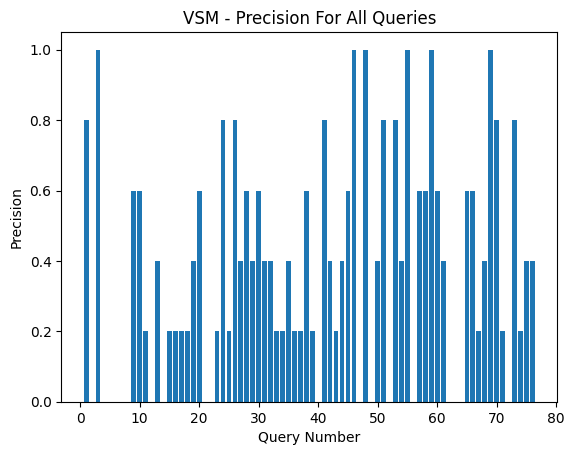

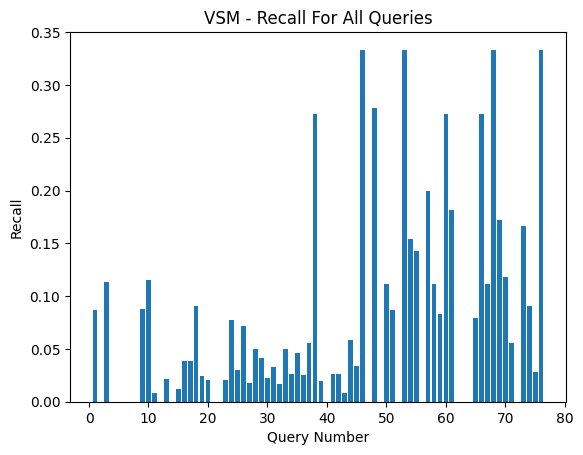

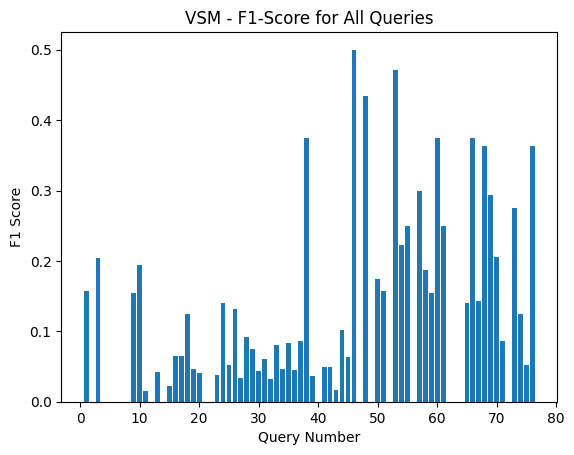

In [34]:
import matplotlib.pyplot as plt

plt.bar(vsm_query_num_precision, vsm_precisions)
plt.xlabel("Query Number")
plt.ylabel("Precision")
plt.title("VSM - Precision For All Queries")
plt.show()

plt.bar(vsm_query_num_recall, vsm_recalls)
plt.xlabel("Query Number")
plt.ylabel("Recall")
plt.title("VSM - Recall For All Queries")
plt.show()

plt.bar(vsm_query_num_f1, vsm_f1_scores)
plt.xlabel("Query Number")
plt.ylabel("F1 Score")
plt.title("VSM - F1-Score for All Queries")
plt.show()


In [ ]:
for i, retrieved_doc in enumerate(rel_retrieved_documents):
    # retrieves relevant documents for the query
    relevant_doc = next(rd for rd in relevant_documents if rd['query_id'] == retrieved_doc['query_id'])
    retrieved_set = set(retrieved_doc['retrieved_document_ids'])
    relevant_set = set(relevant_doc['relevant_document_ids'])
    true_positives = len(retrieved_set.intersection(relevant_set))
    precision = true_positives / len(retrieved_set) # calculates precision

    # prints out individual precision values for each query based on the VS model
    #print(f"Query: {relevant_doc['query_id']} Precision: {precision}")


In [35]:
n = len(vsm_precisions)
VSM_map = sum(vsm_precisions) / n
print(f"The mean average precision of our Vector Space Model is: {VSM_map}")

The mean average precision of our Vector Space Model is: 0.3789473684210526


In [ ]:
MAP_sabs_queries = 0.32763157894736833
MAP_sobs_queries = 0.3171052631578948 # why is this different

**BM25 Evaluation**

In [36]:
# Create lists to store query numbers and precisions
BM25query_nums_precision = []
BM25precisions = []

# Calculate precision for each of the first 5 queries
for i, BM25_relevant_doc in enumerate(BM25_relevant_docs):

    try:
        # Get the corresponding relevant documents for the query
        retrieved_doc = next(rd for rd in rel_retrieved_documents if rd['query_id'] == BM25_relevant_doc['query_id'])
        relevant_doc = next(rd for rd in relevant_documents if rd['query_id'] == BM25_relevant_doc['query_id'])
        
        # Calculate precision
        BM25retrieved_set = set(BM25_relevant_doc['retrieved_document_ids'])
        BM25relevant_set = set(relevant_doc['relevant_document_ids'])
        BM25true_positives = len(BM25relevant_set.intersection(BM25retrieved_set))
        BM25precision = BM25true_positives / len(BM25retrieved_set)

        # Append query number and precision to lists
        BM25query_nums_precision.append(i+1)
        BM25precisions.append(BM25precision)
    except StopIteration:
        pass  # do nothing, simply move on to the next iteration

print('The BM25 Mean Average Precision across all Queries is:',(sum(BM25precisions)/len(BM25precisions)*100),'%')

The BM25 Mean Average Precision across all Queries is: 32.36842105263157 %


In [37]:
# Define a function to calculate recall
def calculate_recall(relevant_docs, retrieved_docs):
    retrieved_set = set(retrieved_docs)
    relevant_set = set(relevant_docs)
    true_positives = len(relevant_set.intersection(retrieved_set))
    recall = true_positives / len(relevant_set)
    return recall

# Calculate recall for each of the first 5 queries
BM25query_nums_recall = []
BM25recalls = []

for i, BM25_relevant_doc in enumerate(BM25_relevant_docs):

    try:
        # Get the corresponding relevant documents for the query
        retrieved_doc = next(rd for rd in rel_retrieved_documents if rd['query_id'] == BM25_relevant_doc['query_id'])
        relevant_doc = next(rd for rd in relevant_documents if rd['query_id'] == BM25_relevant_doc['query_id'])

        # Calculate recall
        BM25retrieved_docs = BM25_relevant_doc['retrieved_document_ids']
        BM25relevant_docs = relevant_doc['relevant_document_ids']
        BM25recall = calculate_recall(BM25relevant_docs, BM25retrieved_docs)

        # Append query number and recall to lists
        BM25query_nums_recall.append(i+1)
        BM25recalls.append(BM25recall)
    except StopIteration:
        pass

print('The BM25 Average Recall across all Queries is:',(sum(BM25recalls)/len(BM25recalls)*100),'%')
BM25_map = sum(BM25precisions)/len(BM25precisions)

The BM25 Average Recall across all Queries is: 5.494300099550277 %


In [38]:
# Define a function to calculate precision
def calculate_precision(relevant_docs, retrieved_docs):
    # Convert the lists to sets for faster calculations
    relevant_docs_set = set(relevant_docs)
    retrieved_docs_set = set(retrieved_docs)

    # Calculate the intersection of relevant_docs_set and retrieved_docs_set
    intersection = relevant_docs_set.intersection(retrieved_docs_set)

    # Calculate precision
    precision = len(intersection) / len(retrieved_docs)

    return precision

# Define a function to calculate recall
def calculate_recall(relevant_docs, retrieved_docs):
    # Convert the lists to sets for faster calculations
    relevant_docs_set = set(relevant_docs)
    retrieved_docs_set = set(retrieved_docs)

    # Calculate the intersection of relevant_docs_set and retrieved_docs_set
    intersection = relevant_docs_set.intersection(retrieved_docs_set)

    # Calculate recall
    recall = len(intersection) / len(relevant_docs)

    return recall

# Define a function to calculate F1 score
def calculate_f1_score(precision, recall):
    if precision == 0 or recall == 0:
        return 0
    else:
        f1_score = 2 * (precision * recall) / (precision + recall)
        return f1_score

# Calculate F1 score for each of the first 5 queries
BM25query_nums_f1_score = []
BM25f1_scores = []

for i, BM25_relevant_doc in enumerate(BM25_relevant_docs):

    try:
        # Get the corresponding relevant documents for the query
        retrieved_doc = next(rd for rd in rel_retrieved_documents if rd['query_id'] == BM25_relevant_doc['query_id'])
        relevant_doc = next(rd for rd in relevant_documents if rd['query_id'] == BM25_relevant_doc['query_id'])

        # Calculate precision and recall
        BM25retrieved_docs = BM25_relevant_doc['retrieved_document_ids']
        BM25relevant_docs = relevant_doc['relevant_document_ids']
        BM25precision = calculate_precision(BM25relevant_docs, BM25retrieved_docs)
        BM25recall = calculate_recall(BM25relevant_docs, BM25retrieved_docs)

        # Calculate F1 score
        BM25f1_score = calculate_f1_score(BM25precision, BM25recall)

        # Append query number and F1 score to lists
        BM25query_nums_f1_score.append(i+1)
        BM25f1_scores.append(BM25f1_score)
    except StopIteration:
        pass

print('The BM25 Average F1-Score across all Queries is:',(sum(BM25f1_scores)/len(BM25f1_scores)*100),'%')

The BM25 Average F1-Score across all Queries is: 8.6032161990757 %


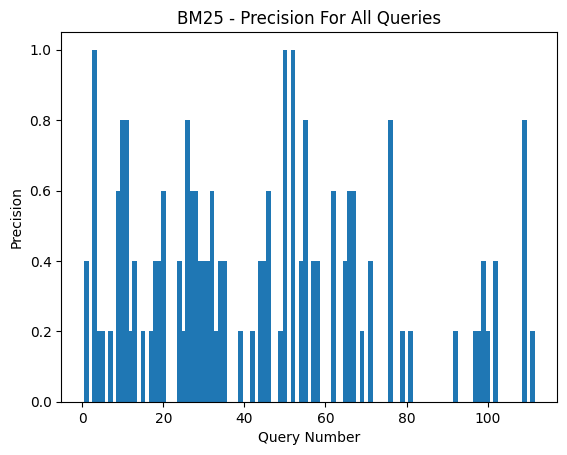

The BM25 Mean Average Precision across all Queries is: 32.36842105263157 %


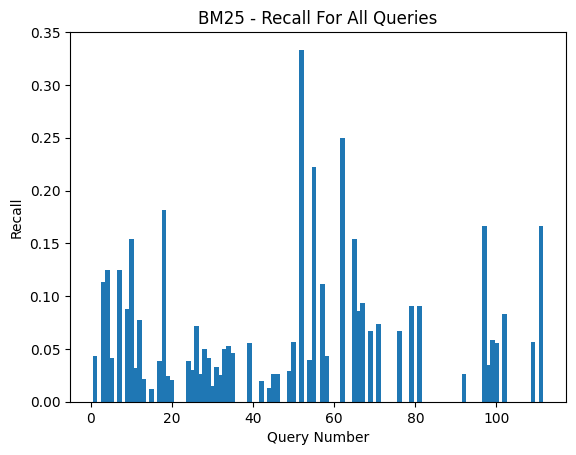

The BM25 Average Recall across all Queries is: 5.494300099550277 %


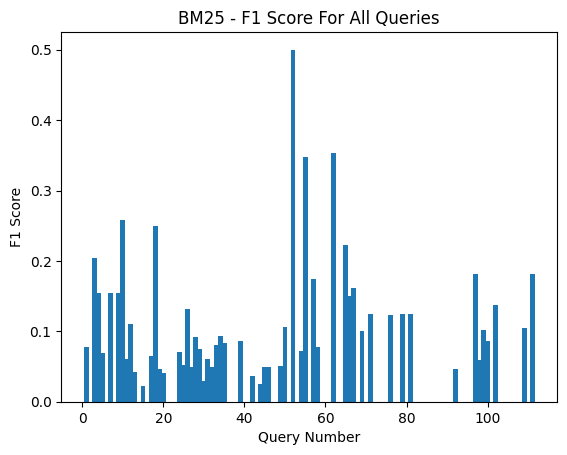

The BM25 Average F1-Score across all Queries is: 8.6032161990757 %


In [ ]:
# Create bar chart
bar_width = 1.2
plt.bar(BM25query_nums_precision, BM25precisions, width=bar_width)
plt.xlabel("Query Number")
plt.ylabel("Precision")
plt.title("BM25 - Precision For All Queries")
plt.show()

print('The BM25 Mean Average Precision across all Queries is:',(sum(BM25precisions)/len(BM25precisions)*100),'%')

# Create bar chart for recall
bar_width = 1.2
plt.bar(BM25query_nums_recall, BM25recalls, width=bar_width)
plt.xlabel("Query Number")
plt.ylabel("Recall")
plt.title("BM25 - Recall For All Queries")
plt.show()

print('The BM25 Average Recall across all Queries is:',(sum(BM25recalls)/len(BM25recalls)*100),'%')

# Create bar chart for F1 score
bar_width = 1.2
plt.bar(BM25query_nums_f1_score, BM25f1_scores, width=bar_width)
plt.xlabel("Query Number")
plt.ylabel("F1 Score")
plt.title("BM25 - F1 Score For All Queries")
plt.show()

print('The BM25 Average F1-Score across all Queries is:',(sum(BM25f1_scores)/len(BM25f1_scores)*100),'%')

# **Comparative Analysis**

Below we have a visualisation comparing the Mean Average Precision (MAP) scores for both models we have created. MAP takes the precision of each individual query, sums it and divides against the total number of queries. It acts as a robust comparative tool that can assist us in determining which of our models performs best against our project aim.

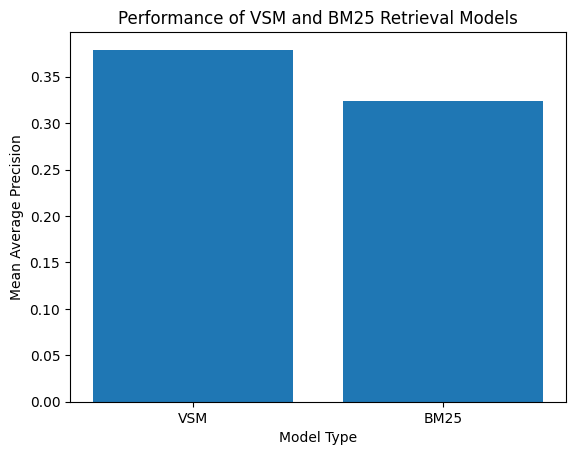

In [39]:
plt.bar(['VSM', 'BM25'], [VSM_map, BM25_map])

# Set the axis labels and title
plt.xlabel('Model Type')
plt.ylabel('Mean Average Precision')
plt.title('Performance of VSM and BM25 Retrieval Models')

# Display the plot
plt.show()

**Concluding statements**

VSM performed better than BM25. We don't really know why

# **Optimisation Steps (if any)**

- try stemming instead of lemmatization
- preprocessing needs to be fine-tuned and checked again
- tune the bm25 model's parameters if possible